## Importing Relevant Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import punkt

# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D

# # Global Parameters
# stop_words = set(stopwords.words('english'))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
datapath = '/content/drive/MyDrive/archive/Dataset_SA'
data = pd.read_csv("/content/drive/MyDrive/archive/Dataset_SA.csv")

In [ ]:
data.head()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


In [ ]:
data.shape

(205052, 6)

## Data Cleaning

In [ ]:
data.isna()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
205047,False,False,False,False,False,False
205048,False,False,False,False,False,False
205049,False,False,False,False,False,False
205050,False,False,False,False,False,False


In [ ]:
data.isna().sum()

product_name         0
product_price        0
Rate                 0
Review           24664
Summary             11
Sentiment            0
dtype: int64

In [ ]:
data["Review"].fillna("", inplace=True) #Puts empty strings in all column values of Review where NA written
data.dropna(inplace=True) #drops all the NA values
data["Summary"].fillna("No summary available", inplace=True) #Puts "No summary available" in all values of Summary column where NA

In [ ]:
data.isna().sum()

product_name     0
product_price    0
Rate             0
Review           0
Summary          0
Sentiment        0
dtype: int64

## Data Visualisation

In [ ]:
num_reviews_per_class = {}
c1 = c2 = c3 = 0

for index, value in data['Sentiment'].items():
    if value == "positive":
      c1 = c1+1
    elif value == 'negative':
      c2 = c2+1
    else:
      c3 = c3+1

num_reviews_per_class['positive'] = c1
num_reviews_per_class['negative'] = c2
num_reviews_per_class['neutral'] = c3
print(num_reviews_per_class)

{'positive': 166575, 'negative': 28232, 'neutral': 10234}


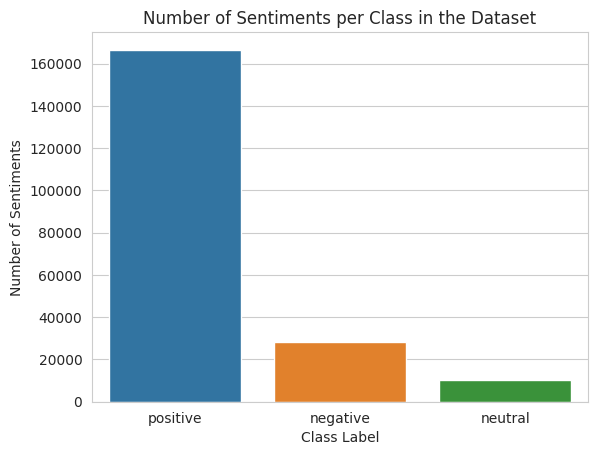

In [ ]:
# Create a bar plot of the number of sentiments per class using Seaborn
sns.set_style("whitegrid")
sns.barplot(x=list(num_reviews_per_class.keys()), y=list(num_reviews_per_class.values()))
plt.xlabel("Class Label")
plt.ylabel("Number of Sentiments")
plt.title("Number of Sentiments per Class in the Dataset")
plt.show()

## Preprocessing Data

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
data['Review'] = data['Review'].astype(str)

def textcleaning(inputtxt):
  inputtxt = re.sub(r"[^a-zA-Z]", " ", inputtxt)
  inputtxt = " ".join(inputtxt)
  return inputtxt

In [ ]:
data["Review"] = data["Review"].apply(textcleaning)
data["Summary"] = data["Summary"].apply(textcleaning)

data['Review'] = data['Review'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
data['Summary'] = data['Summary'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Convert text to lowercase
data['Review'] = data['Review'].str.lower()
data['Summary'] = data['Summary'].str.lower()

In [ ]:
# Tokenize text
data['Review'] = data['Review'].apply(lambda x: word_tokenize(x))
data['Summary'] = data['Summary'].apply(lambda x: word_tokenize(x))

# Remove stop words
stop_words = set(stopwords.words('english'))
data['Review'] = data['Review'].apply(lambda x: [word for word in x if word not in stop_words])
data['Summary'] = data['Summary'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatize text
lemmatizer = WordNetLemmatizer()
data['Review'] = data['Review'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
data['Summary'] = data['Summary'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Join tokens back into sentences
data['Review'] = data['Review'].apply(lambda x: ' '.join(x))
data['Summary'] = data['Summary'].apply(lambda x: ' '.join(x))

In [ ]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector

## Performing Sentiment Analysis

In [ ]:
data['input_text'] = data['Review'] + ' ' + data['Summary']

In [ ]:
from textblob import TextBlob

data['Sentiment Polarity'] = data['input_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Classify sentiment as positive, negative, or neutral based on polarity threshold
data['sentiment_label'] = data['Sentiment Polarity'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

In [ ]:
from sklearn.metrics import accuracy_score

ground_truth_sentiments = data['Sentiment']
predicted_sentiments = data['sentiment_label']

# Calculate accuracy
accuracy = accuracy_score(ground_truth_sentiments, predicted_sentiments)

# Print accuracy
print("Accuracy:", accuracy)

Accuracy: 0.04991196882574705


In [ ]:
data.head()

,product_name,product_price,Rate,Review,Summary,Sentiment,input_text,Sentiment Polarity,sentiment_label
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,u p e r,g r e c l e r e x c e l l e n r f l w n f r h ...,positive,u p e r g r e c l e r e x c e l l e n r f l w ...,0.0,neutral
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,w e e,b e b u g e f c l e r n c e c l n g,positive,w e e b e b u g e f c l e r n c e c l n g,0.0,neutral
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,f r,h e q u l g b u h e p w e r f r e c e n,positive,f r h e q u l g b u h e p w e r f r e c e n,0.0,neutral
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,u e l e p r u c,v e r b p r u c n l f n,negative,u e l e p r u c v e r b p r u c n l f n,0.0,neutral
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,f r,k k p r u c,neutral,f r k k p r u c,0.0,neutral


### Loading Dataset

In [ ]:
tf_vector = get_feature_vector(np.array(data['input_text']).ravel())
X = tf_vector.transform(np.array(data['input_text'].ravel()))
y = np.array(data['Sentiment']).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

ValueError: ignored

### Naive Bayes

In [ ]:
# Training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)
print(accuracy_score(y_test, y_predict_nb))

### Logistics Regreession

In [ ]:
# Training Logistics Regression model
LR_model = LogisticRegression(solver='lbfgs')
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
print(accuracy_score(y_test, y_predict_lr))

### CNN

In [ ]:
from keras.preprocessing.text import Tokenizer

# Convert text data to numerical data
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data["Summary"].values)

maxlen = 30
X = tokenizer.texts_to_sequences(data["Summary"].values)
X_padded = np.zeros((len(X), maxlen))

for i, seq in enumerate(X):
    if len(seq) > maxlen:
        seq = seq[:maxlen]
    X_padded[i, :len(seq)] = seq

y = pd.get_dummies(data["Sentiment"]).values

In [ ]:
X_padded.shape

In [ ]:
# FOR UNDERSAMPLING

from imblearn.under_sampling import RandomUnderSampler

# Instantiate a RandomUnderSampler object
undersampler = RandomUnderSampler(random_state=42)

# Perform undersampling on the data
X_undersampled, y_undersampled = undersampler.fit_resample(X, y)

# X is the feature matrix (input data)
# y is the target vector (labels)

# X_undersampled and y_undersampled are the undersampled feature matrix and target vector, respectively

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

In [ ]:
X = np.array(X_padded)
model = Sequential()
model.add(Embedding(5000, 128, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu')) # Add Conv1D layer
model.add(MaxPooling1D(pool_size=2)) # Add MaxPooling1D layer
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
prodreview = model.fit(X_train, y_train, epochs=15, batch_size=40, validation_split=0.2)

In [ ]:
score, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", accuracy)

In [ ]:
plt.plot(prodreview.history['val_accuracy'])
plt.plot(prodreview.history["accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Validation Accuracy","Accuracy"])
plt.show()

In [ ]:
plt.plot(prodreview.history['val_loss'])
plt.plot(prodreview.history['loss'])
plt.title("Loss of Model with Epochs")
plt.xlabel("Epoch")
plt.ylabel("Model Loss")
plt.legend(["Validation Loss","Loss"])
plt.show()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

words = " ".join(data["Summary"].values)
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Task 3

In [ ]:
negative_reviews = data[data['sentiment_label'] == 'negative']
positive_reviews = data[data['sentiment_label'] == 'positive']
neutral_reviews = data[data['sentiment_label'] == 'neutral']

In [ ]:
# Extract aspects from negative and positive summaries
# You can use any appropriate technique such as keyword extraction or topic modeling
# Here's an example using keyword extraction with TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')

# Fit and transform summaries for negative reviews
negative_summary_tfidf = vectorizer.fit_transform(negative_reviews['Summary'])

# Fit and transform summaries for positive reviews
positive_summary_tfidf = vectorizer.fit_transform(positive_reviews['Summary'])

# Fit and transform summaries for positive reviews
neutral_summary_tfidf = vectorizer.fit_transform(neutral_reviews['Summary'])

In [ ]:
from sklearn.cluster import KMeans

# Initialize K-means clustering for negative aspects
kmeans_negative = KMeans(n_clusters=10, random_state=0).fit(negative_summary_tfidf)

# Get cluster labels for negative aspects
negative_reviews['aspect_cluster'] = kmeans_negative.labels_

# Perform clustering on positive aspects
# You can use any appropriate clustering technique such as K-means, hierarchical clustering, or DBSCAN
# Here's an example using K-means

# Initialize K-means clustering for positive aspects
kmeans_positive = KMeans(n_clusters=10, random_state=0).fit(positive_summary_tfidf)

# Get cluster labels for positive aspects
positive_reviews['aspect_cluster'] = kmeans_positive.labels_

# Initialize K-means clustering for neutral aspects
kmeans_neutral = KMeans(n_clusters=10, random_state=0).fit(neutral_summary_tfidf)

# Get cluster labels for neutral aspects
neutral_reviews['aspect_cluster'] = kmeans_neutral.labels_

In [ ]:
top_negative_reasons = negative_reviews.groupby('aspect_cluster')['Summary'].apply(lambda x: ' '.join(x)).reset_index()
top_negative_reasons = top_negative_reasons.sort_values(by='aspect_cluster', ascending=False)
top_negative_reasons['top_reasons'] = top_negative_reasons['Summary'].apply(lambda x: ' '.join(x.split()[:10]))

# Get top reasons for positive reviews
top_positive_reasons = positive_reviews.groupby('aspect_cluster')['Summary'].apply(lambda x: ' '.join(x)).reset_index()
top_positive_reasons = top_positive_reasons.sort_values(by='aspect_cluster', ascending=False)
top_positive_reasons['top_reasons'] = top_positive_reasons['Summary'].apply(lambda x: ' '.join(x.split()[:10]))

# Get top reasons for neutral reviews
top_neutral_reasons = neutral_reviews.groupby('aspect_cluster')['Summary'].apply(lambda x: ' '.join(x)).reset_index()
top_neutral_reasons = top_neutral_reasons.sort_values(by='aspect_cluster', ascending=False)
top_neutral_reasons['top_reasons'] = top_neutral_reasons['Summary'].apply(lambda x: ' '.join(x.split()[:10]))

# Print top reasons for negative and positive reviews
print("Top reasons for negative reviews:")
print(top_negative_reasons[['aspect_cluster', 'top_reasons']])
print("\nTop reasons for positive reviews:")
print(top_positive_reasons[['aspect_cluster', 'top_reasons']])
print("\nTop reasons for neutral reviews:")
print(top_neutral_reasons[['aspect_cluster', 'top_reasons']])

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

words = " ".join(top_positive_reasons['top_reasons'])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

words = " ".join(top_negative_reasons['top_reasons'])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

words = " ".join(top_neutral_reasons['top_reasons'])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Load the sentiment analysis results for the whole dataset
sentiment_results = pd.read_csv('sentiment_results.csv')

# Filter sentiment analysis results for a specific product
product_name = 'Product1'
product_sentiments = sentiment_results[sentiment_results['Product'] == product_name]

# Print sentiment analysis results for the specific product
print("Sentiment analysis results for", product_name, ":")
print(product_sentiments['sentiment'].value_counts())